<a href="https://colab.research.google.com/github/AggelosRDio/MscMachineLearning/blob/master/MLFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Final Project

## Library Installs

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


## Library Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, early_stopping
from catboost import CatBoostRegressor
from torch.utils.data import Dataset, DataLoader


## Data Loading

In [3]:
train_features = pd.read_csv('train_hh_features.csv')
train_labels = pd.read_csv('train_hh_gt.csv')
train_rates = pd.read_csv('train_rates_gt.csv')
test_features = pd.read_csv('test_hh_features.csv')

### Data Merge & Basic Statistics

In [4]:
train_data = train_features.merge(train_labels, on=['survey_id', 'hhid'], how='left')
train_data.head()

,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id,cons_ppp17
0,100001,1,75,4,594.80627,Female,1,0,0,0,...,No,No,No,Yes,Yes,Yes,Yes,No,100000,25.258402
1,100002,1,150,4,1676.27230,Female,2,0,0,0,...,No,No,No,No,Yes,Yes,No,No,100000,16.996706
2,100003,1,375,4,506.93719,Male,5,0,0,2,...,Yes,No,Yes,Yes,Yes,Yes,No,Yes,100000,13.671848
3,100004,1,375,4,824.61786,Male,5,0,0,1,...,Yes,No,No,No,Yes,Yes,No,No,100000,7.189475
4,100005,1,525,4,351.47644,Male,7,1,0,0,...,No,No,Yes,No,Yes,Yes,Yes,No,100000,12.308855


In [5]:
train_data.describe()

,hhid,com,weight,strata,utl_exp_ppp17,hsize,num_children5,num_children10,num_children18,age,...,sfworkershh,region1,region2,region3,region4,region5,region6,region7,survey_id,cons_ppp17
count,104234.000000,104234.0,104234.000000,104234.000000,104149.000000,104234.000000,104234.000000,104234.000000,104234.000000,104234.000000,...,104234.000000,104234.000000,104234.000000,104234.000000,104234.000000,104234.000000,104234.000000,104234.000000,104234.000000,104234.000000
mean,222499.501497,1.0,926.357254,4.424813,510.439284,3.611653,0.287872,0.338066,0.571004,52.589414,...,0.320479,0.232736,0.157166,0.106395,0.053150,0.235959,0.098653,0.115941,205059.769365,11.555229
std,83279.120172,0.0,1121.680081,2.429095,437.475542,1.927880,0.561682,0.598281,0.831472,15.732361,...,0.400869,0.422577,0.363959,0.308344,0.224333,0.424599,0.298197,0.320156,81587.641825,10.034225
min,100001.000000,1.0,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100000.000000,0.359563
25%,126059.250000,1.0,270.000000,2.000000,190.115800,2.000000,0.000000,0.000000,0.000000,41.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100000.000000,5.439294
50%,219929.500000,1.0,582.000000,5.000000,411.917570,3.000000,0.000000,0.000000,0.000000,52.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200000.000000,8.774002
75%,311403.750000,1.0,1128.000000,7.000000,722.440060,5.000000,0.000000,1.000000,1.000000,64.000000,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,300000.000000,14.216931
max,337462.000000,1.0,23832.000000,8.000000,5880.471200,21.000000,5.000000,6.000000,6.000000,98.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,300000.000000,236.115680


In [6]:
train_data['cons_ppp17'].describe() # this is our target

,cons_ppp17
count,104234.000000
mean,11.555229
std,10.034225
min,0.359563
25%,5.439294
50%,8.774002
75%,14.216931
max,236.115680


In [7]:
missing = train_data.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)

sector1d           14129
dweltyp             1206
utl_exp_ppp17         85
consumed5000          66
consumed4600          56
consumed4900          56
consumed4800          56
consumed4500          54
consumed4400          52
consumed4700          52
consumed4300          52
employed              45
consumed4200          44
consumed3900          40
consumed4100          40
consumed4000          38
consumed3800          35
consumed3700          29
consumed3500          24
consumed3600          23
share_secondary       23
educ_max              23
consumed3400          22
consumed3300          20
consumed3200          15
consumed3100          13
consumed3000          10
consumed2600           7
consumed2200           7
consumed2900           7
consumed1700           5
consumed1400           5
consumed2800           5
consumed1300           5
consumed1200           5
consumed2500           4
consumed1800           4
consumed1000           4
consumed1100           4
consumed1600           4


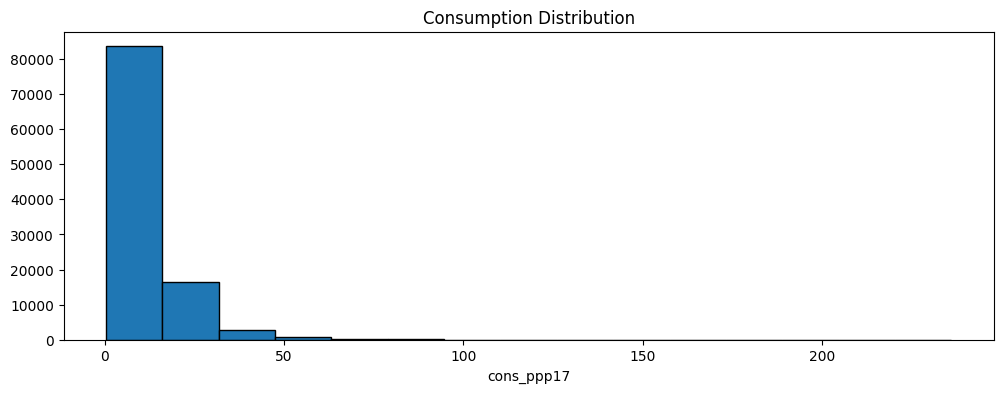

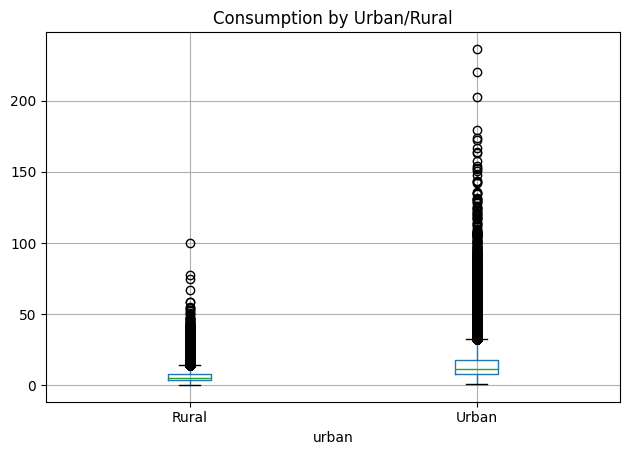

In [8]:
plt.figure(figsize=(12, 4))
plt.hist(train_data['cons_ppp17'], bins=15, edgecolor='black')
plt.title('Consumption Distribution')
plt.xlabel('cons_ppp17')

train_data.boxplot(column='cons_ppp17', by='urban')
plt.title('Consumption by Urban/Rural')
plt.suptitle('')
plt.tight_layout()
plt.show()

In [9]:
numeric_features = train_data.select_dtypes(include=[np.number]).columns
correlations = train_data[numeric_features].corr()['cons_ppp17'].sort_values(ascending=False)
print(correlations)

cons_ppp17          1.000000
utl_exp_ppp17       0.445324
sfworkershh         0.369261
region7             0.300099
region1             0.129630
region2             0.064078
region3             0.054948
age                 0.048768
hhid                0.020543
survey_id           0.016384
share_secondary     0.016087
num_elderly        -0.001501
weight             -0.027724
region4            -0.052414
num_adult_male     -0.057781
num_adult_female   -0.078122
region6            -0.161238
sworkershh         -0.180566
num_children5      -0.188142
num_children10     -0.203503
num_children18     -0.221311
hsize              -0.272773
region5            -0.309193
strata             -0.445995
com                      NaN
Name: cons_ppp17, dtype: float64


## Feature Engineering

In [10]:
def engineer_household_features(df):
  df = df.copy()

  df['children_ratio'] = (df['num_children5'] + df['num_children10'] + df['num_children18']) / df['hsize'].replace(0, 1)
  df['elderly_ratio'] = (df['num_elderly']) / df['hsize'].replace(0, 1)
  df['adults_ratio'] = (df['num_adult_female'] + df['num_adult_male']) / df['hsize'].replace(0, 1)
  df['dependency_ration'] = (df['num_children5'] + df['num_children10'] + df['num_children18'] + df['num_elderly']) / df['hsize'].replace(0, 1)

  return df


def engineer_employment_quality_features(df):
  df = df.copy()

  df['workers_per_capita'] = df['sworkershh'] / df['hsize'].replace(0, 1)
  df['employment_quality'] = df['sfworkershh'] * df['sworkershh']

  return df

def engineer_house_quality_feature(df):
  df = df.copy()

  housing_features = ['water', 'toilet', 'sewer', 'elect', 'owner']

  for feature in housing_features:
    df[feature] = pd.to_numeric(df[feature].replace({'Access': 1, 'No access': 0, 'Owner': 1, 'Not owner': 0}), errors='coerce')

  df['housing_quality'] = (df['water'] + df['toilet'] + df['sewer'] + df['elect'] + df['owner']) / 5

  return df

def engineer_food_consumption_features(df):
  df = df.copy()

  food_cols = [col for col in df.columns if col.startswith('consumed')]
  for col in food_cols:
    df[col] = pd.to_numeric(df[col].replace({'Yes': 1, 'No': 0}), errors='coerce')

  df['food_diversity'] = df[food_cols].sum(axis=1)
  df['basic_food_diversity'] = df[food_cols[:10]].sum(axis=1)

  protein_cols = ['consumed800', 'consumed900', 'consumed700', 'consumed2000', 'consumed400']

  for col in protein_cols:
    df[col] = pd.to_numeric(df[col].replace({'Yes': 1, 'No': 0}), errors='coerce')

  df['protein_consumption'] = df[protein_cols].sum(axis=1)

  # df.drop(columns=protein_cols_numeric, inplace=True)
  # 'consumed800' -> BEEF
  # 'consumed900' -> CHICKEN
  # 'consumed700' -> EGGS
  # 'consumed2000' -> FISH
  # 'consumed400' -> MILK

  return df

def engineer_age_features(df):
  df = df.copy()

  df['age_squared'] = df['age'] ** 2
  df['age_category'] = pd.cut(df['age'], bins=[0, 30, 45, 60, 100], labels=['young', 'middle', 'senior', 'elderly'])

  return df

def engineer_education_features(df):
  df = df.copy()

  education_map = {
        'Never attended': 0,
        'Incomplete Primary Education': 1,
        'Complete Primary Education': 2,
        'Incomplete Secondary Education': 3,
        'Complete Secondary Education': 4,
        'Incomplete Tertiary Education': 5,
        'Complete Tertiary Education': 6
  }
  df['educ_max'] = pd.to_numeric(df['educ_max'].replace(education_map), errors='coerce')

  df['education_index'] = df['educ_max'] * df['share_secondary']

  return df



def engineer_features(df):
  df = df.copy()

  df = engineer_household_features(df)
  df = engineer_employment_quality_features(df)
  df = engineer_house_quality_feature(df)
  df = engineer_food_consumption_features(df)
  df = engineer_age_features(df)
  df = engineer_education_features(df)

  return df


In [11]:
train_data_backup = train_data.copy()
train_data = engineer_features(train_data)
test_features_backup = test_features.copy()
test_features = engineer_features(test_features)

/tmp/ipython-input-1384055852.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[feature] = pd.to_numeric(df[feature].replace({'Access': 1, 'No access': 0, 'Owner': 1, 'Not owner': 0}), errors='coerce')
/tmp/ipython-input-1384055852.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = pd.to_numeric(df[col].replace({'Yes': 1, 'No': 0}), errors='coerce')
/tmp/ipython-input-1384055852.py:78: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavio

## Preprocessing

In [12]:
categorical_features = ['male', 'owner', 'water', 'toilet', 'sewer', 'elect',
                       'employed', 'any_nonagric', 'urban', 'age_category',
                       'water_source', 'sanitation_source', 'dweltyp',
                       'educ_max', 'sector1d']

food_features = [col for col in train_data.columns if col.startswith('consumed')]
region_features = [col for col in train_data.columns if col.startswith('region')]

# Features to exclude
exclude_features = ['hhid', 'com', 'survey_id', 'cons_ppp17', 'sample', 'strata', 'weight']
exclude_features += [col for col in train_data.columns if col.startswith('_pline')]

# Get all features
all_features = [col for col in train_data.columns if col not in exclude_features]

# Prepare data
X = train_data[all_features].copy()
y = train_data['cons_ppp17'].copy()

print(all_features)
X_test = test_features[all_features].copy()

['utl_exp_ppp17', 'male', 'hsize', 'num_children5', 'num_children10', 'num_children18', 'age', 'owner', 'water', 'toilet', 'sewer', 'elect', 'water_source', 'sanitation_source', 'dweltyp', 'num_adult_female', 'num_adult_male', 'num_elderly', 'employed', 'sworkershh', 'share_secondary', 'educ_max', 'sfworkershh', 'any_nonagric', 'sector1d', 'region1', 'region2', 'region3', 'region4', 'region5', 'region6', 'region7', 'urban', 'consumed100', 'consumed200', 'consumed300', 'consumed400', 'consumed500', 'consumed600', 'consumed700', 'consumed800', 'consumed900', 'consumed1000', 'consumed1100', 'consumed1200', 'consumed1300', 'consumed1400', 'consumed1500', 'consumed1600', 'consumed1700', 'consumed1800', 'consumed1900', 'consumed2000', 'consumed2100', 'consumed2200', 'consumed2300', 'consumed2400', 'consumed2500', 'consumed2600', 'consumed2700', 'consumed2800', 'consumed2900', 'consumed3000', 'consumed3100', 'consumed3200', 'consumed3300', 'consumed3400', 'consumed3500', 'consumed3600', 'cons

### Categorical Variables & Missing Values

In [13]:
def convert_categorical_to_numeric(df):
  df = df.copy()

  binary_map = {'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0,
                  'Employed': 1, 'Not employed': 0, 'Urban': 1, 'Rural': 0}

  binary_cols = ['male', 'employed', 'any_nonagric', 'urban']

  for col in binary_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col].replace(binary_map), errors='coerce')

  if 'age_category' in df.columns:
    age_map = {'young': 0, 'middle': 1, 'senior': 2, 'elderly': 3}
    df['age_category'] = df['age_category'].map(age_map)


  numeric_cat_cols = ['water_source', 'sanitation_source', 'dweltyp', 'sector1d']
  for col in numeric_cat_cols:
    if col in df.columns:
      df[col] = pd.to_numeric(df[col], errors='coerce')

  return df

In [14]:
def impute_missing_values(df):
  df = df.copy()

  cat_cols = df.select_dtypes(include=['category']).columns
  num_cols = df.select_dtypes(exclude=['category']).columns

  for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0] if len(X[col].mode()) > 0 else df[col].cat.categories[0])

  for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

  df[num_cols]= df[num_cols].fillna(df[num_cols].median())

  return df



In [15]:
X = convert_categorical_to_numeric(X)
X_test = convert_categorical_to_numeric(X_test)

/tmp/ipython-input-1406749733.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = pd.to_numeric(df[col].replace(binary_map), errors='coerce')
/tmp/ipython-input-1406749733.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = pd.to_numeric(df[col].replace(binary_map), errors='coerce')


In [16]:
X = impute_missing_values(X)
X_test = impute_missing_values(X_test)

## Model Training

We will train multiple tree-based models and compare performance.
We're testing model capacity, generalization, feature importance

Algorithms to be tested:

  - LightGBM: Fast, good for large datasets
  - XGBoost: Robust, handles missing data well
  - CatBoost: Excellent for categorical features
  - Random Forest: Good baseline, less prone to overfitting

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### LightGBM

In [18]:
import lightgbm as lgb

lgb_params = {
    'objective': 'regression',        # Predicting continuous values
    'metric': 'rmse',                 # Root Mean Squared Error
    'boosting_type': 'gbdt',          # Gradient Boosting Decision Tree
    'num_leaves': 31,                 # Complexity of each tree
    'learning_rate': 0.05,            # Small = slower but more accurate
    'feature_fraction': 0.8,          # Use 80% features per tree (prevents overfitting)
    'bagging_fraction': 0.8,          # Use 80% samples per tree
    'bagging_freq': 5,                # Perform bagging every 5 iterations
    'verbose': -1,
    'n_estimators': 1000
}

lgb_model = LGBMRegressor(**lgb_params)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[ lgb.early_stopping(stopping_rounds = 50) ])

lgb_pred = lgb_model.predict(X_val)
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_pred))
lgb_mae = mean_absolute_error(y_val, lgb_pred)
lgb_r2 = r2_score(y_val, lgb_pred)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[462]	valid_0's rmse: 5.9046


### XGBoost

In [19]:
xgb_params = {
    'objective': 'reg:squarederror',  # Regression with squared error
    'learning_rate': 0.05,
    'max_depth': 6,                   # Maximum tree depth
    'subsample': 0.8,                 # Sample 80% of data
    'colsample_bytree': 0.8,          # Sample 80% of features
    'n_estimators': 1000,
    'random_state': 42
}

xgb_model = XGBRegressor(**xgb_params, enable_categorical=True)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)

xgb_pred = xgb_model.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
xgb_mae = mean_absolute_error(y_val, xgb_pred)
xgb_r2 = r2_score(y_val, xgb_pred)

[0]	validation_0-rmse:9.78742
[100]	validation_0-rmse:6.03246
[200]	validation_0-rmse:5.93805
[300]	validation_0-rmse:5.91791
[400]	validation_0-rmse:5.91354
[500]	validation_0-rmse:5.92193
[600]	validation_0-rmse:5.92574
[700]	validation_0-rmse:5.93129
[800]	validation_0-rmse:5.94267
[900]	validation_0-rmse:5.95294
[999]	validation_0-rmse:5.96201


### CatBoost

In [20]:
cat_params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,                       # Tree depth
    'l2_leaf_reg': 3,                 # L2 regularization
    'verbose': 100,
    'random_state': 42
}

X_train_cat = X_train.copy()
X_val_cat = X_val.copy()

cat_model = CatBoostRegressor(**cat_params)

for col in categorical_features:
    if col in X_train_cat.columns:
        X_train_cat[col] = X_train_cat[col].astype(str).replace('nan', -1)
        X_val_cat[col] = X_val_cat[col].astype(str).replace('nan', -1)

cat_model.fit(X_train_cat, y_train,
             eval_set=(X_val_cat, y_val),
             cat_features=categorical_features,
             verbose=100)

cat_pred = cat_model.predict(X_val_cat)

cat_rmse = np.sqrt(mean_squared_error(y_val, cat_pred))
cat_mae = mean_absolute_error(y_val, cat_pred)
cat_r2 = r2_score(y_val, cat_pred)

/tmp/ipython-input-4212687854.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train_cat[col] = X_train_cat[col].astype(str).replace('nan', -1)
/tmp/ipython-input-4212687854.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_val_cat[col] = X_val_cat[col].astype(str).replace('nan', -1)
/tmp/ipython-input-4212687854.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the fu

0:	learn: 9.8248404	test: 9.8083778	best: 9.8083778 (0)	total: 263ms	remaining: 4m 22s
100:	learn: 6.1839875	test: 6.2085437	best: 6.2085437 (100)	total: 13s	remaining: 1m 55s
200:	learn: 5.9770544	test: 6.0647704	best: 6.0647704 (200)	total: 18.8s	remaining: 1m 14s
300:	learn: 5.8443655	test: 5.9924183	best: 5.9924183 (300)	total: 25.9s	remaining: 1m
400:	learn: 5.7466147	test: 5.9611003	best: 5.9611003 (400)	total: 31.5s	remaining: 47.1s
500:	learn: 5.6685267	test: 5.9431643	best: 5.9430351 (497)	total: 38.4s	remaining: 38.2s
600:	learn: 5.5922620	test: 5.9256438	best: 5.9254618 (599)	total: 44s	remaining: 29.2s
700:	learn: 5.5296099	test: 5.9120714	best: 5.9119861 (699)	total: 51s	remaining: 21.8s
800:	learn: 5.4766716	test: 5.9033303	best: 5.9032407 (795)	total: 56.4s	remaining: 14s
900:	learn: 5.4316897	test: 5.8988712	best: 5.8988712 (900)	total: 1m 3s	remaining: 6.94s
999:	learn: 5.3914463	test: 5.8902235	best: 5.8902235 (999)	total: 1m 8s	remaining: 0us

bestTest = 5.890223537


In [21]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=5, random_state=42, n_jobs=-1)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)


rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
rf_mae = mean_absolute_error(y_val, rf_pred)
rf_r2 = r2_score(y_val, rf_pred)


In [22]:
results_df = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'CatBoost',
              'Random Forest'],
    'RMSE': [lgb_rmse, xgb_rmse, cat_rmse,
             rf_rmse],
    'MAE': [lgb_mae, xgb_mae, cat_mae,
            rf_mae],
    'R²': [lgb_r2, xgb_r2, cat_r2,
           rf_r2]
})
results_df = results_df.sort_values('RMSE')

results_df

,Model,RMSE,MAE,R²
2,CatBoost,5.890224,3.303920,0.654677
0,LightGBM,5.904601,3.321253,0.652989
1,XGBoost,5.962009,3.334855,0.646209
3,Random Forest,6.233844,3.536012,0.613211


## Deep Learning

### PyTorch Dataset

In [23]:
class ConsumptionDataset(Dataset):
  def __init__(self, X, y = None):
    self.X = torch.FloatTensor(X.values)
    self.y = torch.FloatTensor(y.values) if y is not None else None

  def __getitem__(self, index):
    if self.y is not None:
      return self.X[index], self.y[index]

    return self.X[index]

  def __len__(self):
    return len(self.X)

### NN Architecture

In [24]:
class ConsumptionNN(nn.Module):
  def __init__(self, input_dim):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.3),

        nn.Linear(256, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.2),

        nn.Linear(128, 64),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.Dropout(0.2),

        nn.Linear(64, 1)
    )

  def forward(self, x):
      return self.model(x).squeeze()

## Data Normalization

In [25]:
scaler = StandardScaler()

# X_train_clean = X_train_rf.fillna(0)
# X_val_clean = X_val_rf.fillna(0)
X_train_clean = X_train.fillna(0)
X_val_clean = X_val.fillna(0)
y_train_clean = y_train.fillna(y_train.median())
y_val_clean = y_val.fillna(y_val.median())

# Replace inf with large numbers
X_train_clean = X_train_clean.replace([np.inf, -np.inf], 0)
X_val_clean = X_val_clean.replace([np.inf, -np.inf], 0)

X_train_scaled = scaler.fit_transform(X_train_clean)
X_val_scaled = scaler.transform(X_val_clean)


## Create Data Loaders

In [26]:

# ========== CREATE DATA LOADERS ==========
train_dataset = ConsumptionDataset(pd.DataFrame(X_train_scaled), y_train)
val_dataset = ConsumptionDataset(pd.DataFrame(X_val_scaled), y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nn_model = ConsumptionNN(X_train.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

for epoch in range(50):
    nn_model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()          # Reset gradients
        outputs = nn_model(X_batch)    # Forward pass
        loss = criterion(outputs, y_batch)  # Calculate loss

        if torch.isnan(loss):
          print(f"NaN loss at epoch {epoch}")
          break

        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        train_loss += loss.item()

    if epoch % 10 == 0:
        avg_loss = train_loss/len(train_loader)
        print(f"Epoch {epoch:2d} | Loss: {avg_loss:.4f}")


Epoch  0 | Loss: 69.8223
Epoch 10 | Loss: 37.9092
Epoch 20 | Loss: 36.0069
Epoch 30 | Loss: 34.7265
Epoch 40 | Loss: 34.1039


In [28]:
nn_model.eval()
with torch.no_grad():
  nn_pred = nn_model(torch.FloatTensor(X_val_scaled).to(device)).cpu().numpy()

nn_rmse = np.sqrt(mean_squared_error(y_val, nn_pred))
nn_mae = mean_absolute_error(y_val, nn_pred)
nn_r2 = r2_score(y_val, nn_pred)

## Model Ensemble

### Weighted Ensemble

In [29]:
ensemble_pred = (0.35 * lgb_pred +
                0.35 * xgb_pred +
                0.20 * cat_pred +
                0.10 * nn_pred)

ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_pred))
ensemble_mae = mean_absolute_error(y_val, ensemble_pred)
ensemble_r2 = r2_score(y_val, ensemble_pred)

### Ensemble Evaluation

In [30]:
comparison = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'CatBoost',
              'Neural Net', 'ENSEMBLE'],
    'RMSE': [lgb_rmse, xgb_rmse, cat_rmse,
             nn_rmse, ensemble_rmse],
    'MAE': [lgb_mae, xgb_mae, cat_mae,
            nn_mae, ensemble_mae],
    'R²': [lgb_r2, xgb_r2, cat_r2,
           nn_r2, ensemble_r2]
})

best_individual = comparison.iloc[:-1]['RMSE'].min()
improvement = ((best_individual - ensemble_rmse) / best_individual) * 100

In [31]:
print("ENSEMBLE ANALYSIS")
print("="*50)
print(f"Best individual model RMSE: {best_individual:.4f}")
print(f"Ensemble RMSE: {ensemble_rmse:.4f}")
print(f"Improvement: {improvement:.2f}%")

if ensemble_rmse < best_individual:
    print("\nEnsemble outperforms all individual models!")
    print("Reason: Models make different errors; averaging cancels out noise")
else:
    print("\\nEnsemble similar to best model")
    print("Reason: Models might be too similar or weights need tuning")

ENSEMBLE ANALYSIS
Best individual model RMSE: 5.8902
Ensemble RMSE: 5.8567
Improvement: 0.57%

Ensemble outperforms all individual models!
Reason: Models make different errors; averaging cancels out noise


## Feature Importance Analysis

Top 20 most important features:
             feature        avg
       utl_exp_ppp17 678.555356
                 age 320.263454
               hsize 275.198079
      food_diversity 230.062982
            educ_max 148.842659
  workers_per_capita 132.815028
  employment_quality 100.012961
        adults_ratio  97.979820
basic_food_diversity  94.503535
             region7  91.921363
        consumed4600  73.237799
         sfworkershh  73.041548
         age_squared  71.216529
        consumed2600  68.040012
     share_secondary  66.854825
 protein_consumption  62.115670
    num_adult_female  60.089850
          sworkershh  58.726678
   dependency_ration  58.288709
     housing_quality  57.141596


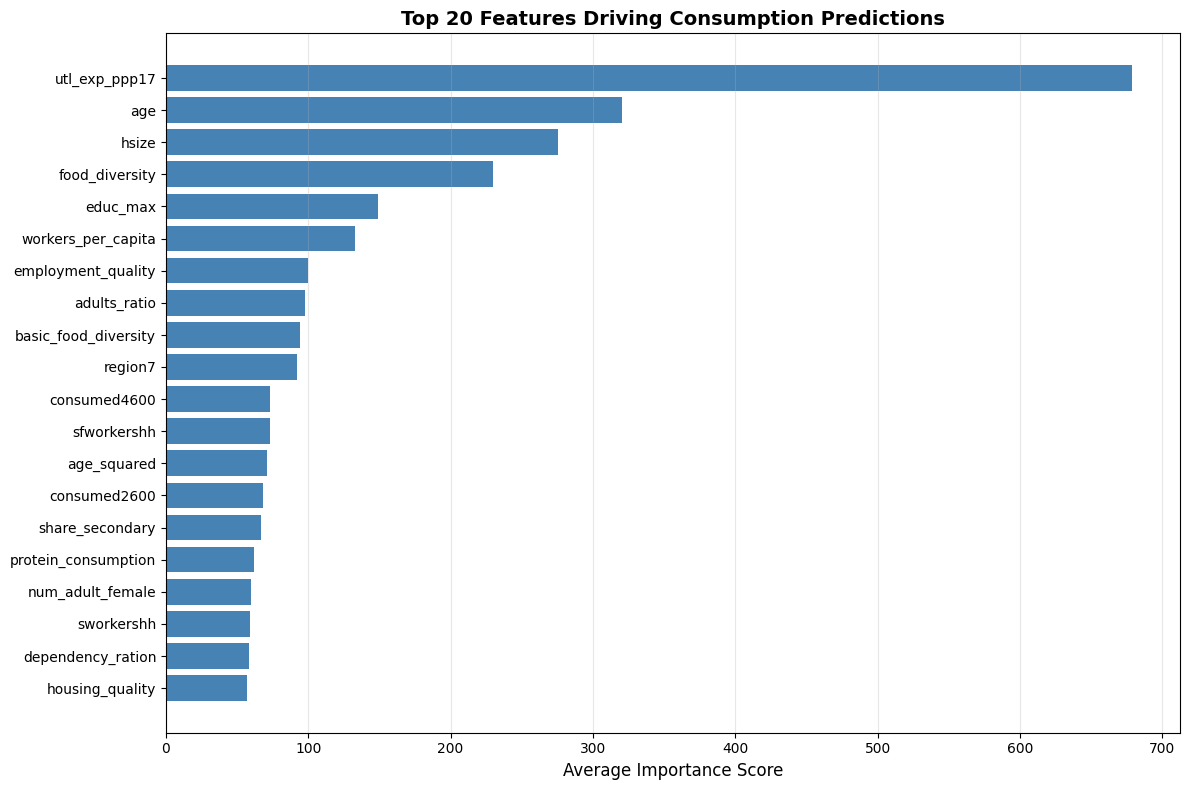

\n==================================================
KEY INSIGHTS FROM FEATURE IMPORTANCE
\nTop 5 predictors of household consumption:
1. utl_exp_ppp17
2. age
3. hsize
4. food_diversity
5. educ_max
\nInterpretation:
- Utility expenditure highly predictive (direct consumption measure)
- Housing quality indicates wealth level
- Employment metrics show income capacity
- Food diversity reflects purchasing power
- Education correlates with earning potential
\nModel Limitations to Consider:
1. Models may struggle with extreme poverty (few examples)
2. Survey differences might affect generalization
3. Cultural factors not fully captured in features
4. Temporal changes not accounted for (static snapshot)


In [32]:
feature_importance = pd.DataFrame({
    'feature': all_features,
    'lgb': lgb_model.feature_importances_,
    'xgb': xgb_model.feature_importances_,
    'cat': cat_model.feature_importances_
})

# Average importance across models for robustness
feature_importance['avg'] = feature_importance[['lgb', 'xgb', 'cat']].mean(axis=1)
feature_importance = feature_importance.sort_values('avg', ascending=False)

print("Top 20 most important features:")
print(feature_importance.head(20)[['feature', 'avg']].to_string(index=False))

# Visualize top features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['avg'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Average Importance Score', fontsize=12)
plt.title('Top 20 Features Driving Consumption Predictions',
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\\n" + "="*50)
print("KEY INSIGHTS FROM FEATURE IMPORTANCE")
print("="*50)

# Analyze top features
top_5 = feature_importance.head(5)['feature'].tolist()
print("\\nTop 5 predictors of household consumption:")
for i, feat in enumerate(top_5, 1):
    print(f"{i}. {feat}")

print("\\nInterpretation:")
print("- Utility expenditure highly predictive (direct consumption measure)")
print("- Housing quality indicates wealth level")
print("- Employment metrics show income capacity")
print("- Food diversity reflects purchasing power")
print("- Education correlates with earning potential")

print("\\nModel Limitations to Consider:")
print("1. Models may struggle with extreme poverty (few examples)")
print("2. Survey differences might affect generalization")
print("3. Cultural factors not fully captured in features")
print("4. Temporal changes not accounted for (static snapshot)")

In [33]:
def prepare_for_catboost(df, categorical_features):
    df = df.copy()
    for col in categorical_features:
        if col in df.columns:
            df[col] = df[col].astype(str).replace('nan', '-1')
    return df


In [34]:
print("\nPredicting with each model...")

print("  1/4 LightGBM...", end='')
lgb_test_pred = lgb_model.predict(X_test)
print(" ✓")


Predicting with each model...
  1/4 LightGBM... ✓


In [35]:
print("  2/4 XGBoost...", end='')
xgb_test_pred = xgb_model.predict(X_test)
print(" ✓")

  2/4 XGBoost... ✓


In [36]:
print("  3/4 CatBoost...", end='')

X_test_cat = X_test.copy()

for col in categorical_features:
    if col in X_test_cat.columns:
      X_test_cat[col] = X_test_cat[col].astype(str).replace('nan', -1)

cat_test_pred = cat_model.predict(X_test_cat)
print(" ✓")

  3/4 CatBoost...

/tmp/ipython-input-3898756253.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test_cat[col] = X_test_cat[col].astype(str).replace('nan', -1)
/tmp/ipython-input-3898756253.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test_cat[col] = X_test_cat[col].astype(str).replace('nan', -1)
/tmp/ipython-input-3898756253.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the futur

 ✓


In [37]:
print("Columns with NaN in X_test:")
nan_cols = X_test.isnull().sum()
print(nan_cols[nan_cols > 0])

for col in X_test.columns:
    if X_test[col].isnull().any():
        if X_test[col].dtype in ['float64', 'int64']:
            # Use training data median
            fill_value = X[col].median() if col in X.columns else 0
            X_test[col].fillna(fill_value, inplace=True)
        else:
            # For categorical, fill with mode or 0
            fill_value = X[col].mode()[0] if col in X.columns and len(X[col].mode()) > 0 else 0
            X_test[col].fillna(fill_value, inplace=True)

for col in X_test.columns:
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

X_test.fillna(0, inplace=True)

Columns with NaN in X_test:
water_source         103023
sanitation_source    103023
dweltyp              103023
sector1d             103023
dtype: int64


/tmp/ipython-input-2977348531.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test[col].fillna(fill_value, inplace=True)


In [38]:
print("  4/4 Neural Network...", end='')
X_test_scaled = scaler.transform(X_test)
nn_model.eval()
with torch.no_grad():
    nn_test_pred = nn_model(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy()
print(" ✓")

  4/4 Neural Network... ✓


In [39]:
# ========== ENSEMBLE PREDICTIONS ==========
print("\nCombining predictions with ensemble weights...")
final_predictions = (0.35 * lgb_test_pred +
                    0.35 * xgb_test_pred +
                    0.20 * cat_test_pred +
                    0.10 * nn_test_pred)

print(f"✓ Generated {len(final_predictions):,} household predictions")
print(f"\nPrediction statistics:")
print(f"  Min:    ${final_predictions.min():.2f}/day")
print(f"  Mean:   ${final_predictions.mean():.2f}/day")
print(f"  Median: ${np.median(final_predictions):.2f}/day")
print(f"  Max:    ${final_predictions.max():.2f}/day")

# Sanity check
if final_predictions.min() < 0:
    print("\\n⚠ Warning: Negative predictions detected, clipping to 0")
    final_predictions = np.maximum(final_predictions, 0)


Combining predictions with ensemble weights...
✓ Generated 103,023 household predictions

Prediction statistics:
  Min:    $1.31/day
  Mean:   $12.46/day
  Median: $10.13/day
  Max:    $140.77/day


## Poverty Rate Calculation


Thresholds: 19 poverty lines
Range: $3.17 to $27.37 per day

Note: Different thresholds represent different poverty depths:
  
- $3.17/day: Extreme poverty (World Bank)

- $6.47/day: Lower-middle income poverty

- $27.37/day: Upper-middle income poverty


Key concept: Sample weights

- Each household represents multiple households in the population

- Weights account for sampling probability

- Must use weights to get accurate population-level estimates


Process:
1. For each survey, identify poor households (below threshold)
2. Sum weights of poor households
3. Divide by total survey weight
4. Result: % of population below poverty line


In [40]:
def calculate_poverty_rates(predictions, survey_ids, weights, thresholds):
    results = []

    for survey_id in survey_ids.unique():
        # Filter to current survey
        mask = survey_ids == survey_id
        survey_preds = predictions[mask]
        survey_weights = weights[mask]

        rates = []
        for threshold in thresholds:
            # Count weighted population below threshold
            weighted_poor = survey_weights[survey_preds < threshold].sum()
            total_weight = survey_weights.sum()

            # Poverty rate = poor population / total population
            poverty_rate = weighted_poor / total_weight if total_weight > 0 else 0
            rates.append(poverty_rate)

        results.append([survey_id] + rates)

    columns = ['survey_id'] + [f'pct_hh_below_{t:.2f}' for t in thresholds]
    return pd.DataFrame(results, columns=columns)

In [41]:
poverty_thresholds = [3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06, 7.70,
                     8.40, 9.13, 9.87, 10.70, 11.62, 12.69, 14.03,
                     15.64, 17.76, 20.99, 27.37]

print("Calculating poverty rates by survey and threshold...")
submission_rates = calculate_poverty_rates(
    final_predictions,
    test_features['survey_id'],
    test_features['weight'],
    poverty_thresholds
)

print(f"✓ Calculated rates for {len(submission_rates)} surveys")
print(f"✓ {len(poverty_thresholds)} thresholds per survey")

Calculating poverty rates by survey and threshold...
✓ Calculated rates for 3 surveys
✓ 19 thresholds per survey


## Create Submission Files

### File 1: Household-level Predictions

In [42]:
submission_hh = pd.DataFrame({
    'survey_id': test_features['survey_id'],
    'hhid': test_features['hhid'],
    'cons_ppp17': final_predictions
})

print(f"\nFile 1: Household consumption predictions")
print(f"  Shape: {submission_hh.shape}")
print(f"  Columns: {list(submission_hh.columns)}")
print(f"  Sample:")
print(submission_hh.head(3).to_string(index=False))


File 1: Household consumption predictions
  Shape: (103023, 3)
  Columns: ['survey_id', 'hhid', 'cons_ppp17']
  Sample:
 survey_id   hhid  cons_ppp17
    400000 400001   10.958925
    400000 400002    6.839344
    400000 400003    9.543120


### File 2: Survey-Level Poverty Rates

In [43]:
print(f"\nFile 2: Poverty rate distributions")
print(f"  Shape: {submission_rates.shape}")
print(f"  Surveys: {len(submission_rates)}")
print(f"  Thresholds: {len(poverty_thresholds)}")
print(f"  Sample (first 3 thresholds):")

print(submission_rates[['survey_id', 'pct_hh_below_3.17',
                        'pct_hh_below_3.94', 'pct_hh_below_4.60']].to_string(index=False))


File 2: Poverty rate distributions
  Shape: (3, 20)
  Surveys: 3
  Thresholds: 19
  Sample (first 3 thresholds):
 survey_id  pct_hh_below_3.17  pct_hh_below_3.94  pct_hh_below_4.60
    400000           0.018128           0.048422           0.086178
    500000           0.011340           0.037055           0.073060
    600000           0.013899           0.042039           0.075024


## File Submissions

In [50]:
submission_hh.to_csv('predicted_household_consumption.csv', index=False)
submission_rates.to_csv('predicted_poverty_distribution.csv', index=False)
